In [7]:
! pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import sys
from google.colab import drive
drive.mount('/content/drive')
sys.path.append(r"/content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# import the necessary packages
from loader_util.projects.siamese import build_siamese_model
from loader_util.projects.siamese import config
from loader_util.projects.siamese import utils
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Lambda
from tensorflow.keras.datasets import mnist
import numpy as np

In [11]:
# load MNIST dataset and scale the pixel values to the range of [0, 1]
print("[INFO] loading MNIST dataset...")
(trainx, trainy), (testx, testy) = mnist.load_data()
trainx = trainx / 255.0
testx = testx / 255.0

# add a channel dimension to the images
trainx = np.expand_dims(trainx, axis=-1)
testx = np.expand_dims(testx, axis=-1)

# prepare the positive and negative pairs
print("[INFO] preparing positive and negative pairs...")
(pair_train, label_train) = utils.make_pairs(trainx, trainy)
(pair_test, label_test) = utils.make_pairs(testx, testy)

[INFO] loading MNIST dataset...
[INFO] preparing positive and negative pairs...
[INFO] looping over: 60000 times......
[INFO] looping over: 10000 times......


In [12]:
# configure the siamese network
print("[INFO] building siamese network...")
imgA = Input(shape=config.img_shape)
imgB = Input(shape=config.img_shape)

featureExtractor = build_siamese_model(config.img_shape)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

# finally, construct the siamese network
distance = Lambda(utils.euclidean_distance)([featsA, featsB])

# notice how here we are not sending outputs from a single node Dense
# with sigmoid activation. we need the pure distance as output
# since the contrast loss will use that directly to calculate loss
model = Model(inputs=[imgA, imgB], outputs=distance)

[INFO] building siamese network...


In [13]:
# compile the model
print("[INFO] compiling model...")
model.compile(loss=utils.contrastive_loss,
              optimizer="adam")

# train the model
print("[INFO] training model...")
history = model.fit(
    [pair_train[:, 0], pair_train[:, 1]], label_train[:],
    validation_data=([pair_test[:, 0], pair_test[:, 1]], label_test[:]),
    batch_size=config.batch_size,
    epochs=config.num_epochs)



[INFO] compiling model...
[INFO] training model...
Epoch 1/100
1875/1875 [==============================] - 14s 6ms/step - loss: 0.2016 - val_loss: 0.1702
Epoch 2/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1761 - val_loss: 0.1533
Epoch 3/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1633 - val_loss: 0.1446
Epoch 4/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1553 - val_loss: 0.1342
Epoch 5/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1504 - val_loss: 0.1310
Epoch 6/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1463 - val_loss: 0.1257
Epoch 7/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1440 - val_loss: 0.1242
Epoch 8/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1417 - val_loss: 0.1203
Epoch 9/100
1875/1875 [==============================] - 12s 6ms/step - loss: 0.1401 - val_loss: 0.1166
Epoch 10/100


[INFO] saving siamese model...


[INFO] plotting training history...


KeyError: ignored

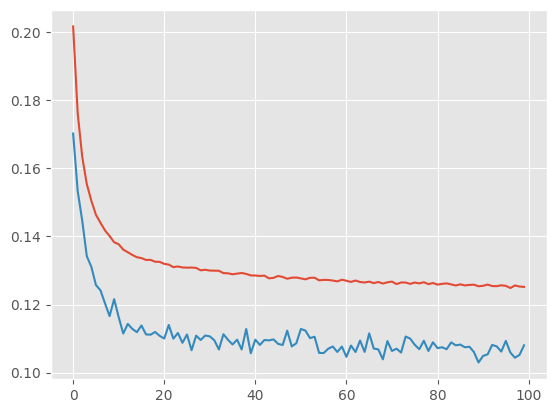

In [14]:
# serialize the model to disk
print("[INFO] saving siamese model...")
model.save(config.contrast_model_path)

# plot the training history
print("[INFO] plotting training history...")
utils.plot_training(history, config.contrast_plot_path)